Python note book to test CLIP with CIFAR-10 data set.

## Project Plan: CLIP with CIFAR-10 and FAISS

### 1. Setup and Initialization
- Install dependencies (`transformers`, `datasets`, `faiss-cpu` or `faiss-gpu`, `torch`, `torchvision`, `scikit-learn`, `matplotlib`).
- Import necessary libraries.
- Check and configure device (CPU/GPU).
- **Update:** Ensure reproducible results by setting random seeds.

### 2. Data Loading (CIFAR-10)
- Load the CIFAR-10 dataset from Hugging Face `datasets`.
- Split into test/train sets (focusing on test set for evaluation).
- Visualize a few random samples to verify data.
- **Optimization:** Use a `DataLoader` for efficient batch processing during embedding generation.

### 3. Model Loading (CLIP)
- Load pretrained CLIP model and processor from `transformers` (e.g., `openai/clip-vit-base-patch32`).
- **Prompt Engineering:** Instead of raw labels ("dog"), use prompt templates (e.g., "a photo of a dog", "a low resolution photo of a dog") to improve zero-shot accuracy on CIFAR-10's low-res images.

### 4. Embedding Generation (Batched)
- **Image Embeddings:** Pass CIFAR-10 images through the CLIP vision model in batches to get feature vectors.
- **Text Embeddings:** Encode the class labels using the CLIP text model.
- **Normalization:** Normalize all vectors to unit length (L2 norm) so that Inner Product (IP) search in FAISS equals Cosine Similarity.

### 5. Indexing with FAISS
- Initialize a FAISS index (e.g., `IndexFlatIP` for inner product/cosine similarity).
- **Optimization:** If dataset grows, consider `IndexIVFFlat` for faster approximate search.
- Add image embeddings to the FAISS index.

### 6. Retrieval Pipeline
- **Zero-Shot Classification:** Query the image-index with text vectors to find the best matching image class.
- **Visual Search (Image-to-Image):** Use a query image to find the nearest neighbors in the dataset (Simulating "product search").

### 7. Evaluation & Metrics
- **Quantitative:**
    - Zero-Shot Accuracy: Percentage of correctly predicted class labels.
    - Top-k Accuracy: (e.g., Top-1, Top-5).
- **Qualitative:**
    - Visualize Top-K retrieval results for specific queries (Show query image next to retrieved results).
    - Generate a **Confusion Matrix** to visualize misclassifications.


In [1]:
# 1. Setup and Initialization
# Install required libraries if not already installed
# %pip install transformers datasets faiss-cpu torch torchvision scikit-learn matplotlib

import torch
import numpy as np
import faiss
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Check device availability
device = "cuda" if torch.cuda.is_available() else "cpu"
# specific for mac m1/m2 chips
if torch.backends.mps.is_available():
    device = "mps"
print(f"Using device: {device}")

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

/Users/hrishikesh/Developer/visual-product-search/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 378485.81 examples/s]


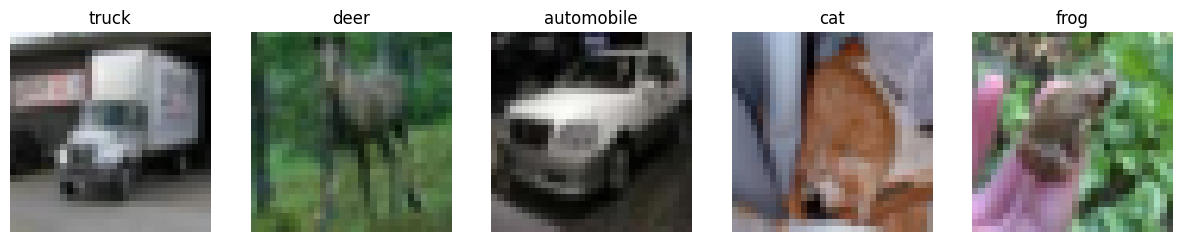

In [2]:
# 2. Data Loading (CIFAR-10)
# Load CIFAR-10 dataset
dataset = load_dataset("cifar10")

# We'll use the test split for evaluation to save time, 
# but you can use 'train' for building a larger index if needed.
test_dataset = dataset["test"]

# Define the class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Visualize a few samples
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    idx = np.random.randint(0, len(test_dataset))
    image = test_dataset[idx]['img']
    label = test_dataset[idx]['label']
    axs[i].imshow(image)
    axs[i].set_title(class_names[label])
    axs[i].axis('off')
plt.show()

In [3]:
# 3. Model Loading (CLIP)
model_id = "openai/clip-vit-base-patch32"

# Load model and processor
model = CLIPModel.from_pretrained(model_id).to(device)
processor = CLIPProcessor.from_pretrained(model_id)

print(f"Model {model_id} loaded successfully on {device}")

Loading weights: 100%|██████████| 398/398 [00:00<00:00, 2014.76it/s, Materializing param=visual_projection.weight]                                
CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
text_model.embeddings.position_ids   | UNEXPECTED |  | 
vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
The image processor of type `CLIPImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Model openai/clip-vit-base-patch32 loaded successfully on mps


In [7]:
# 4. Embedding Generation (Batched)

def get_image_embeddings(dataset, batch_size=32):
    """
    Generates image embeddings for the dataset using the loaded CLIP model.
    """
    all_embeddings = []
    
    # Custom collate function to handle PIL images
    def collate_fn(batch):
        return {
            'img': [item['img'] for item in batch],
            'label': [item['label'] for item in batch]
        }
    
    # Create DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating Image Embeddings"):
            # batch['img'] is now a list of PIL images
            images = batch['img']
            
            # Process images using CLIP processor
            inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
            
            # Get image features
            outputs = model.get_image_features(**inputs)

            # Check if outputs is a tensor or an object (handling different versions)
            if isinstance(outputs, torch.Tensor):
                image_features = outputs
            else:
                # If it's a ModelOutput object, try to get image_embeds or pooler_output
                if hasattr(outputs, 'image_embeds'):
                    image_features = outputs.image_embeds
                elif hasattr(outputs, 'pooler_output'):
                    image_features = outputs.pooler_output
                else:
                    # Fallback accessing by index or printing/raising error
                    image_features = outputs[0]
            
            # Normalize embeddings (important for cosine similarity)
            image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
            
            # Move to CPU and numpy
            all_embeddings.append(image_features.cpu().numpy())
            
    return np.vstack(all_embeddings)

def get_text_embeddings(class_names):
    """
    Generates text embeddings for the class names using prompt templates.
    """
    # Create prompt templates (Prompt Engineering)
    text_prompts = [f"a photo of a {label}" for label in class_names]
    
    # Process text
    inputs = processor(text=text_prompts, padding=True, return_tensors="pt").to(device)
    
    model.eval()
    with torch.no_grad():
        # Get text features
        outputs = model.get_text_features(**inputs)
        
        # Check if outputs is a tensor or an object
        if isinstance(outputs, torch.Tensor):
            text_features = outputs
        else:
             if hasattr(outputs, 'text_embeds'):
                text_features = outputs.text_embeds
             elif hasattr(outputs, 'pooler_output'):
                text_features = outputs.pooler_output
             else:
                text_features = outputs[0]

        # Normalize embeddings
        text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
        
    return text_features.cpu().numpy()

# Generate embeddings
print("Starting embedding generation...")
image_embeddings = get_image_embeddings(test_dataset, batch_size=32)
text_embeddings = get_text_embeddings(class_names)

print(f"Image Embeddings Shape: {image_embeddings.shape}")
print(f"Text Embeddings Shape: {text_embeddings.shape}")

Starting embedding generation...


Generating Image Embeddings: 100%|██████████| 313/313 [00:38<00:00,  8.12it/s]


Image Embeddings Shape: (10000, 512)
Text Embeddings Shape: (10, 512)


In [8]:
# 5. Indexing with FAISS

# Initialize FAISS Index
# Dimension of CLIP embeddings (usually 512 for ViT-B/32)
d = image_embeddings.shape[1] 

# IndexFlatIP uses Inner Product (which is Cosine Similarity for normalized vectors)
index = faiss.IndexFlatIP(d)

# Add image embeddings to the index
index.add(image_embeddings)

print(f"Index created with {index.ntotal} images.")

Index created with 10000 images.


Zero-Shot Classification Accuracy: 88.80%


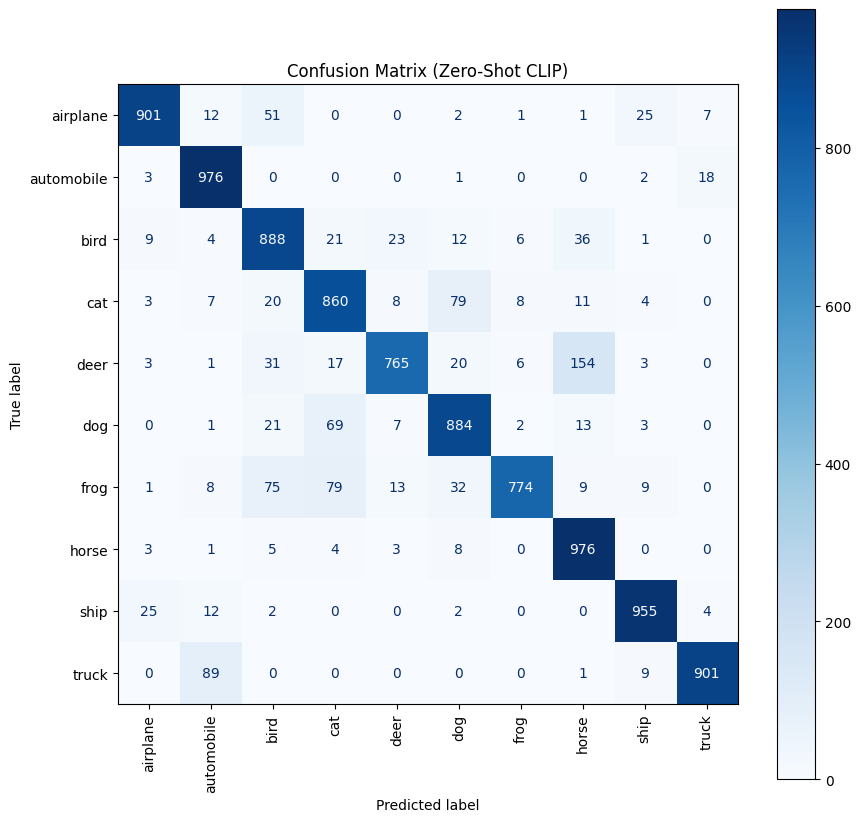

In [9]:
# 6. Retrieval & Evaluation (Zero-Shot Classification)

# Query the index with text embeddings
# k=1 returns the top match (most similar image to the text description) - NOT what we want for classification
# For Zero-Shot Classification, we usually compute similarity of ONE image against ALL text labels.
# BUT, with FAISS, we typically query with a vector to find nearest neighbors.

# APPROACH FOR CLASSIFICATION:
# To classify images, we want to find which Text Embedding is closest to each Image Embedding.
# So we can calculate the similarity matrix (Images x Texts) and pick the max along the text axis.

# Calculate similarity scores (dot product of normalized vectors)
# Shape: (num_images, num_classes)
similarity_scores = image_embeddings @ text_embeddings.T

# Get predicted class indices (argmax across classes)
predicted_indices = np.argmax(similarity_scores, axis=1)

# Get Ground Truth labels
ground_truth = np.array(test_dataset['label'])

# Calculate Accuracy
accuracy = np.mean(predicted_indices == ground_truth)
print(f"Zero-Shot Classification Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(ground_truth, predicted_indices)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix (Zero-Shot CLIP)")
plt.show()

In [10]:
# 7. Additional Metrics: Precision@K and Recall@K
# In a retrieval context, we want to see if the top results for a query (Label) are relevant (Same Label).

def calculate_metrics_at_k(image_embeddings, text_embeddings, ground_truth_labels, k_values=[1, 5, 10, 50, 100]):
    """
    Calculates Precision@K and Recall@K for text-to-image retrieval.
    For each class text embedding, we retrieve top-k images.
    """
    # Calculate similarity: (num_classes, num_images)
    # Note: text_embeddings is (10, 512), image_embeddings is (N, 512)
    # We want rows to be queries (text), cols to be items (images)
    sim_scores_t2i = text_embeddings @ image_embeddings.T
    
    num_classes = text_embeddings.shape[0]
    results = {}
    
    for k in k_values:
        precision_scores = []
        recall_scores = []
        
        # for each class query
        for class_idx in range(num_classes):
            # Get top-k image indices for this class query
            top_k_indices = np.argsort(sim_scores_t2i[class_idx])[::-1][:k]
            
            # Get the true labels of the retrieved images
            retrieved_labels = ground_truth_labels[top_k_indices]
            
            # Check relevance: matches current class_idx
            relevant_retrieved = (retrieved_labels == class_idx).sum()
            
            # Total relevant items in the database for this class
            total_relevant = (ground_truth_labels == class_idx).sum()
            
            # Precision@K: Proportion of retrieved items that are relevant
            precision = relevant_retrieved / k
            
            # Recall@K: Proportion of relevant items that were retrieved
            recall = relevant_retrieved / total_relevant if total_relevant > 0 else 0
            
            precision_scores.append(precision)
            recall_scores.append(recall)
            
        results[f"P@{k}"] = np.mean(precision_scores)
        results[f"R@{k}"] = np.mean(recall_scores)
        
    return results

# Calculate and print metrics
# Note: CIFAR-10 has 1000 images per class in the test set.
k_values = [1, 5, 10, 50, 100, 1000]
metrics = calculate_metrics_at_k(image_embeddings, text_embeddings, ground_truth, k_values)

print("Text-to-Image Retrieval Metrics (Average across 10 classes):")
print("-" * 30)
for k in k_values:
    print(f"Precision@{k}: {metrics[f'P@{k}']:.4f} | Recall@{k}: {metrics[f'R@{k}']:.4f}")

Text-to-Image Retrieval Metrics (Average across 10 classes):
------------------------------
Precision@1: 1.0000 | Recall@1: 0.0010
Precision@5: 0.9800 | Recall@5: 0.0049
Precision@10: 0.9800 | Recall@10: 0.0098
Precision@50: 0.9660 | Recall@50: 0.0483
Precision@100: 0.9680 | Recall@100: 0.0968
Precision@1000: 0.8111 | Recall@1000: 0.8111
